In [270]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from dtaidistance import dtw
from sklearn.metrics.pairwise import cosine_similarity

In [271]:
def fast_dtw_distance(ref, compare_arr):
    distances = np.empty(compare_arr.shape[0])
    for i in range(compare_arr.shape[0]):
        distances[i] = dtw.distance(ref, compare_arr[i])
    distances[distances == 0] = 1
    return distances

def create_time_index(timeend: np.datetime64, window_size: int) -> pd.DatetimeIndex:
    freq = '10min'
    return pd.date_range(end=timeend, periods=window_size, freq=freq)

def safe_nansum(arr, axis=None):
    result = np.nansum(arr, axis=axis)
    # 判斷原始陣列沿 axis 全部是 NaN 的位置
    all_nan = np.isnan(arr).all(axis=axis)
    
    # 將那些位置改為 np.nan
    if np.isscalar(result):
        return np.nan if all_nan else result
    result = result.astype('float64')  # 確保能裝 NaN
    result[all_nan] = np.nan
    return result

In [272]:
a_tdf = pd.DataFrame()
for i in range(0,40):
    try:
        df = pd.read_csv(f'../data/Raw_Data/Gogoro/台北市大安區_臺大二活停車場站A ({i:02d}).csv',index_col=0)
        df.index = pd.to_datetime(df.index)
        df.index = df.index.floor('min')
        df = df[~df.index.duplicated()]
        a_tdf = pd.concat([a_tdf,df])
    except:
        continue
a_tdf = a_tdf[~a_tdf.index.duplicated()]
a_tdf.sort_index(inplace=True)

b_tdf = pd.DataFrame()
for i in range(0,37):
    try:
        df = pd.read_csv(f'../data/Raw_Data/Gogoro/台北市大安區_臺大二活停車場站B ({i:02d}).csv',index_col=0)
        df.index = pd.to_datetime(df.index)
        df.index = df.index.floor('min')
        df = df[~df.index.duplicated()]
        b_tdf = pd.concat([b_tdf,df])
    except:
        continue
b_tdf = b_tdf[~b_tdf.index.duplicated()]
b_tdf.sort_index(inplace=True)

tdf = pd.concat([a_tdf,b_tdf],axis=1).dropna().sum(axis=1)

In [273]:
# 計算時間差（Timedelta 型別）
time_deltas = tdf.index.to_series().diff().dropna()

# 轉為秒數（float 型別）
time_deltas_seconds = time_deltas.dt.total_seconds()/60

# 基本統計量
stats = time_deltas_seconds.describe()

print("時間間隔（分）統計特徵：")
print(stats)

時間間隔（分）統計特徵：
count      5758.000000
mean        155.786037
std        6590.929095
min           1.000000
25%          10.000000
50%          19.000000
75%          35.000000
max      479748.000000
Name: time, dtype: float64


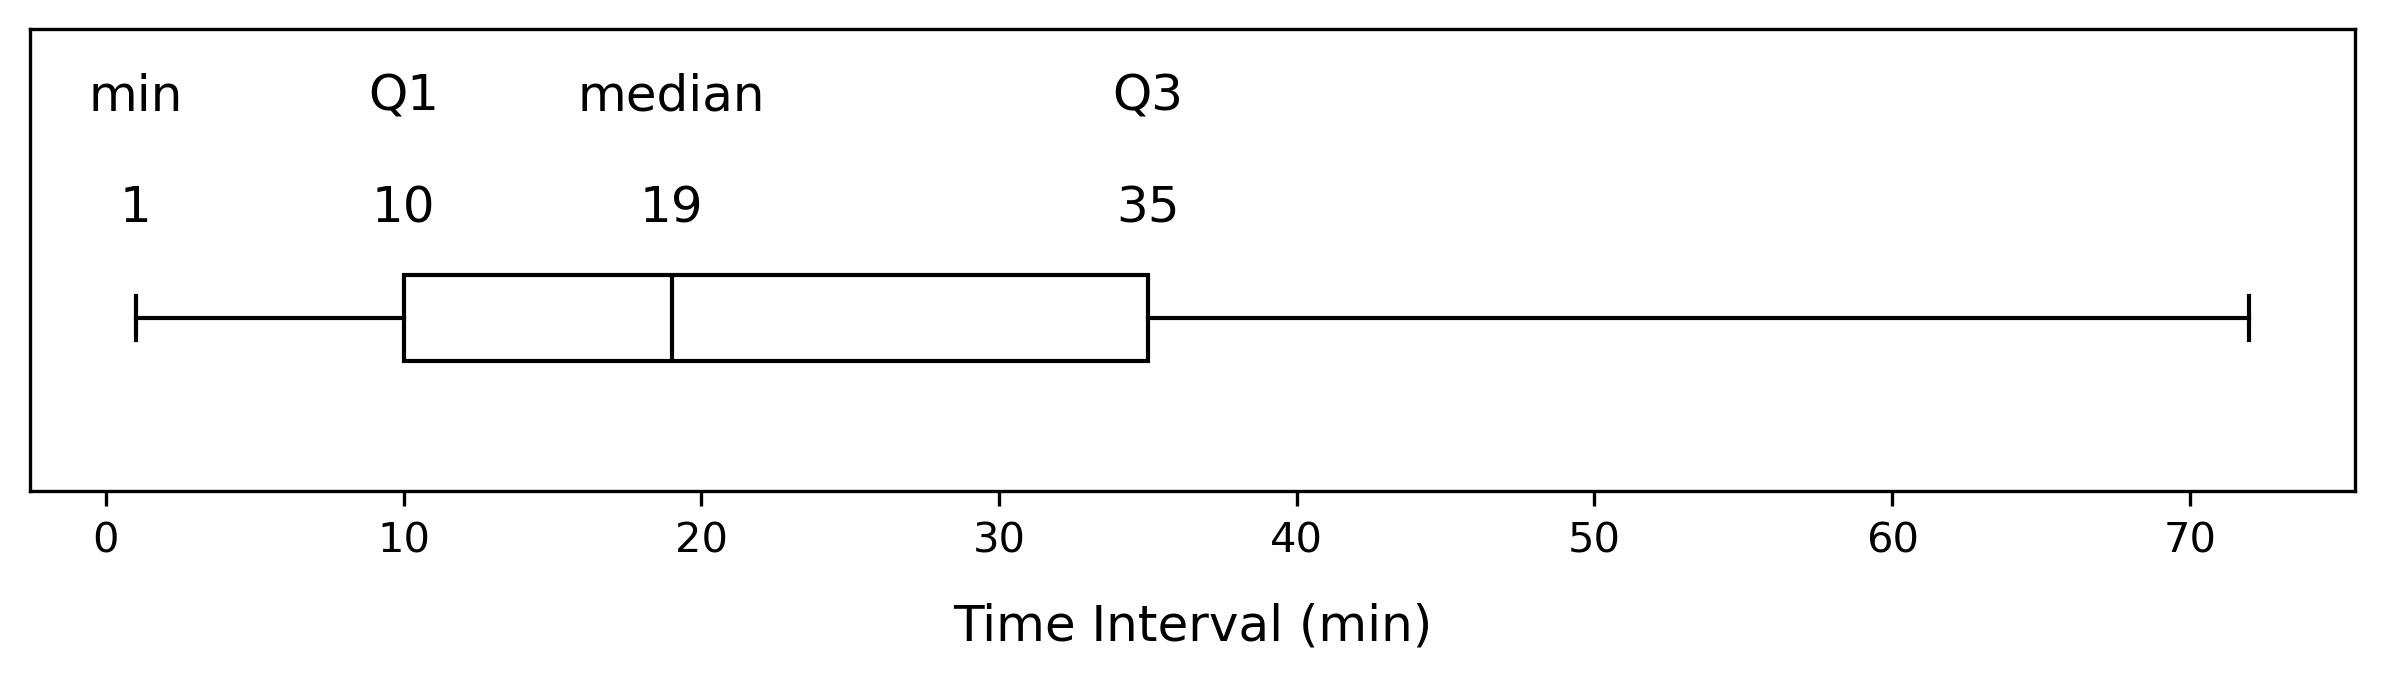

In [274]:
# 顯示統計數值在 boxplot 上
plt.figure(figsize=(10, 2),dpi=300)
plt.boxplot(time_deltas_seconds, vert=False, patch_artist=True, showfliers=False,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

# 標註統計值
stats = time_deltas_seconds.describe()
positions = [stats['min'], stats['25%'], stats['50%'], stats['75%']]
labels = ['min', 'Q1', 'median', 'Q3']

for pos, label in zip(positions, labels):
    # plt.axvline(pos, color='gray', linestyle=':', linewidth=1)
    plt.text(pos, 1.15, f'{label}\n\n{pos:.0f}', fontsize=12, rotation=0, verticalalignment='bottom', horizontalalignment='center')
plt.xlabel('Time Interval (min)',fontsize=12,labelpad=10)
plt.yticks([])
plt.ylim(0.7,None)
# plt.title("時間間隔（分鐘）Boxplot")
# plt.xlabel("時間間隔（分鐘）")
# plt.tight_layout()
# plt.grid(axis='x')
plt.show()

In [275]:
# 假設 df 已經處理好 index 是 datetime 且只保留到分鐘
start = tdf.index.min()
end = tdf.index.max()

# 產生每分鐘的完整時間序列
full_index = pd.date_range(start=start, end=end, freq='1min')

# 將原始 df 補上缺的時間，空值保持為 NaN
tdf_filled = tdf.reindex(full_index)

tdf_filled = tdf_filled.resample('20min').mean()
tdf_filled.name = 'raw_data'

In [276]:
# 轉為 xarray DataArray
da = xr.DataArray(tdf_filled, dims='time')

# 定義滑動視窗參數
window_size = 6 * 3    # 72 個點（12 小時 * 每10分鐘）
step_size = 1         # 每 1 小時（6 個點）滑動一次

# 建立滑動視窗
rolling_windows = da.rolling(time=window_size, center=False).construct('window')

# 下採樣：每 step_size 個點保留一個視窗
sampled_windows = rolling_windows.isel(time=slice(0, None, step_size))

# 將結果轉為 numpy 陣列 (samples, time steps)
samples = sampled_windows.transpose('time', 'window').values

# 篩選掉含 nan 的視窗
valid_mask = np.isnan(samples).sum(axis=1) < window_size-2
samples = samples[valid_mask]
index = sampled_windows.transpose('time', 'window')['time'].values[valid_mask]

In [277]:
from collections import defaultdict
# 建立 dict：key 是 shape[1]（欄位數），value 是對應的 shape[0] 組合
shape_dict = defaultdict(list)

for i in range(samples.shape[0]):
    ref_con = ~np.isnan(samples[i])
    target_con = ~np.any(np.isnan(samples[:, ref_con]), axis=1)
    sub_samples = samples[target_con][:, ref_con]
    shape = sub_samples.shape
    shape_dict[shape[1]].append(shape[0])
# 整理輸出
shape_dict = dict(shape_dict)
shape_dict_sorted = dict(sorted(shape_dict.items()))  # 依變數數量排序

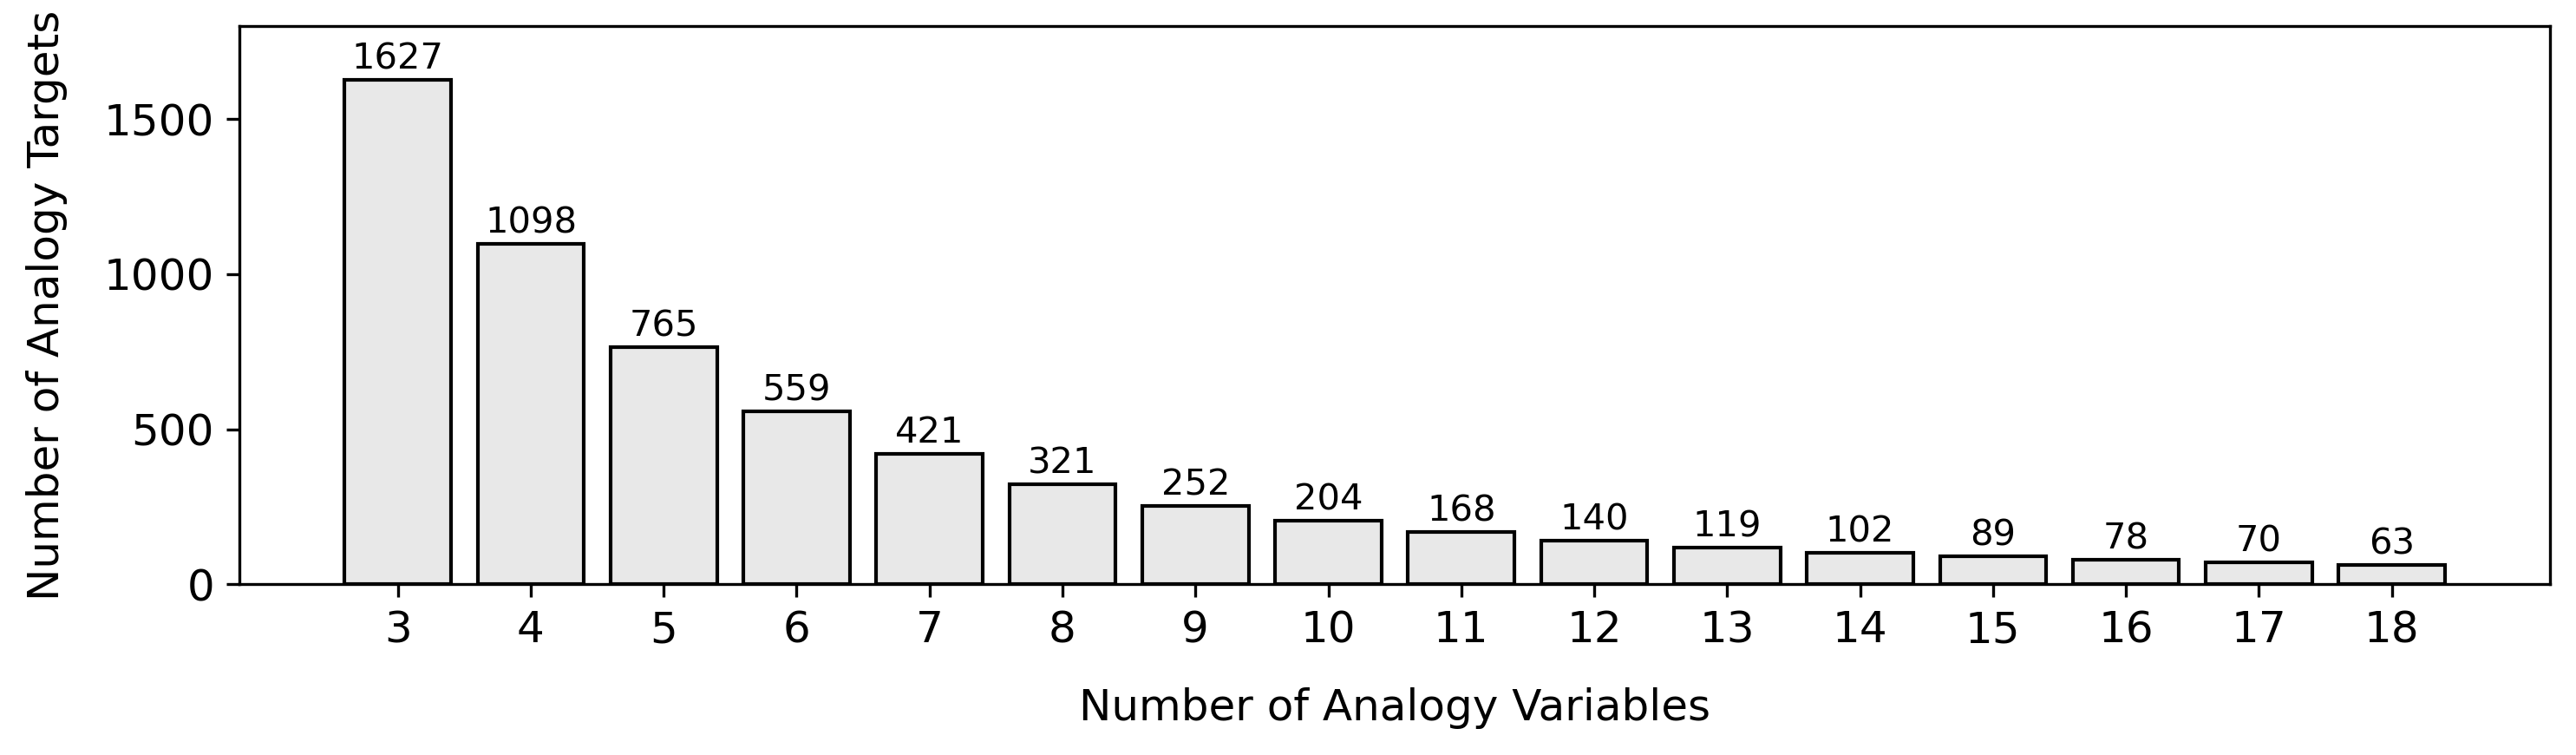

In [323]:
# 轉換 defaultdict 為統計數據：每個 shape[1] 對應的所有 shape[0] 次數總和
shape_counts = {k: np.mean(v) for k, v in shape_dict_sorted.items()}

# 繪製 bar plot
plt.figure(figsize=(10, 3),dpi=300)
bars = plt.bar(shape_counts.keys(), shape_counts.values(), color='#E8E8E8', edgecolor='black')
plt.xlabel("Number of Analogy Variables", fontsize=12, labelpad=10)  # 用於類比的變數數量
plt.ylabel("Number of Analogy Targets", fontsize=12, labelpad=10)    # 可被類比的目標數量
plt.xticks(list(shape_counts.keys()),fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1800)
# 在每個 bar 上標示數值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [279]:
i = 0
ref_con = ~np.isnan(samples[i])
target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
target_mean = np.nanmean(samples[target_con,:], axis=1, keepdims=True)  # shape = (20, 1)
target_std = np.nanstd(samples[target_con,:], axis=1, keepdims=True)    # shape = (20, 1)
target_zscore_arr = (samples[target_con,:] - target_mean) / (target_std + 1e-8)
ref_mean = np.nanmean(samples[i])
ref_std = np.nanstd(samples[i])
ref_zscore_arr = (samples[i] - ref_mean) / (ref_std + 1e-8)
distance = fast_dtw_distance(ref_zscore_arr[ref_con], target_zscore_arr[:,ref_con])  # shape = (881,)
inverse_distance = 1/distance
inverse_distance[0] = 0
weight = inverse_distance**p
valid_mask = ~np.isnan(samples[target_con,:])
weighted_mask = weight[:,None]*valid_mask
col_weight_sum = np.sum(weighted_mask, axis=0, keepdims=True)
col_weight_sum[col_weight_sum==0]=1
norm_weight  = weighted_mask/col_weight_sum
result = np.nansum((target_zscore_arr*ref_std+ref_mean)*norm_weight,axis=0)
timeend = index[i]
time_index = create_time_index(timeend, window_size)
series = pd.Series(result, index=time_index, name=samples[target_con,:][:,ref_con].shape[1])

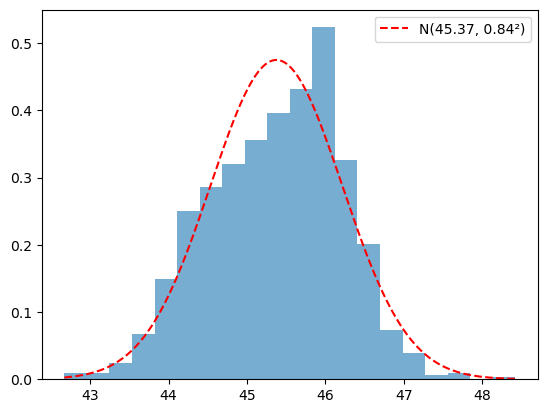

In [280]:
from scipy.stats import norm
import matplotlib.pyplot as plt

data = pd.Series((target_zscore_arr*ref_std+ref_mean)[:,~ref_con][:,11]).dropna()
# 假設你有原始資料 data
mu, std = norm.fit(data)

# 畫出擬合的常態分布
x = np.linspace(min(data), max(data), 1000)
pdf = norm.pdf(x, mu, std)

plt.hist(data, bins=20, density=True, alpha=0.6)
plt.plot(x, pdf, 'r--', label=f'N({mu:.2f}, {std:.2f}²)')
plt.legend()
plt.show()

In [281]:
p = 2
series_list = []
for i in range(samples.shape[0]):
    ref_con = ~np.isnan(samples[i])
    target_con = ~np.any(np.isnan(samples[:,ref_con]),axis=1)
    target_mean = np.nanmean(samples[target_con,:], axis=1, keepdims=True)  # shape = (20, 1)
    target_std = np.nanstd(samples[target_con,:], axis=1, keepdims=True)    # shape = (20, 1)
    target_zscore_arr = (samples[target_con,:] - target_mean) / (target_std + 1e-8)
    ref_mean = np.nanmean(samples[i])
    ref_std = np.nanstd(samples[i])
    ref_zscore_arr = (samples[i] - ref_mean) / (ref_std + 1e-8)
    distance = fast_dtw_distance(ref_zscore_arr[ref_con], target_zscore_arr[:,ref_con])  # shape = (881,)

    if distance.shape[0] == 1:
        continue
    
    inverse_distance = 1/distance
    inverse_distance[0] = 0
    weight = inverse_distance**p
    valid_mask = ~np.isnan(samples[target_con,:])
    weighted_mask = weight[:,None]*valid_mask
    col_weight_sum = np.sum(weighted_mask, axis=0, keepdims=True)
    col_weight_sum[col_weight_sum==0]=1
    norm_weight  = weighted_mask/col_weight_sum
    result = np.nansum((target_zscore_arr*ref_std+ref_mean)*norm_weight,axis=0)
    result[ref_con] = samples[i][ref_con]
    timeend = index[i]
    time_index = create_time_index(timeend, window_size)
    series = pd.Series(result, index=time_index, name=samples[target_con,:][:,ref_con].shape[1])
    series_list.append(series)
analogy_result = pd.concat(series_list, axis=1)

In [297]:
# 假設 df 已經處理好 index 是 datetime 且只保留到分鐘
start = tdf_filled.index.min()
end = tdf_filled.index.max()

# 產生每分鐘的完整時間序列
full_index = pd.date_range(start=start, end=end, freq='20min')

# 將原始 df 補上缺的時間，空值保持為 NaN
analogy_result_filled = analogy_result.reindex(full_index)

In [298]:
valid_mask = ~np.isnan(analogy_result_filled.values)
weight = (pd.DataFrame(np.tile(analogy_result_filled.columns.to_numpy(), (analogy_result_filled.shape[0], 1)))).values
weight = np.exp(weight)
weighted_mask = weight*valid_mask
col_weight_sum = np.sum(weighted_mask, axis=1, keepdims=True)
col_weight_sum[col_weight_sum==0]=1
norm_weight  = weighted_mask/col_weight_sum
result = safe_nansum(analogy_result_filled.values*norm_weight,axis=1)
result = pd.Series(result, index=analogy_result_filled.index,name='analogy_result')
result[tdf_filled.dropna().index] = tdf_filled.dropna()

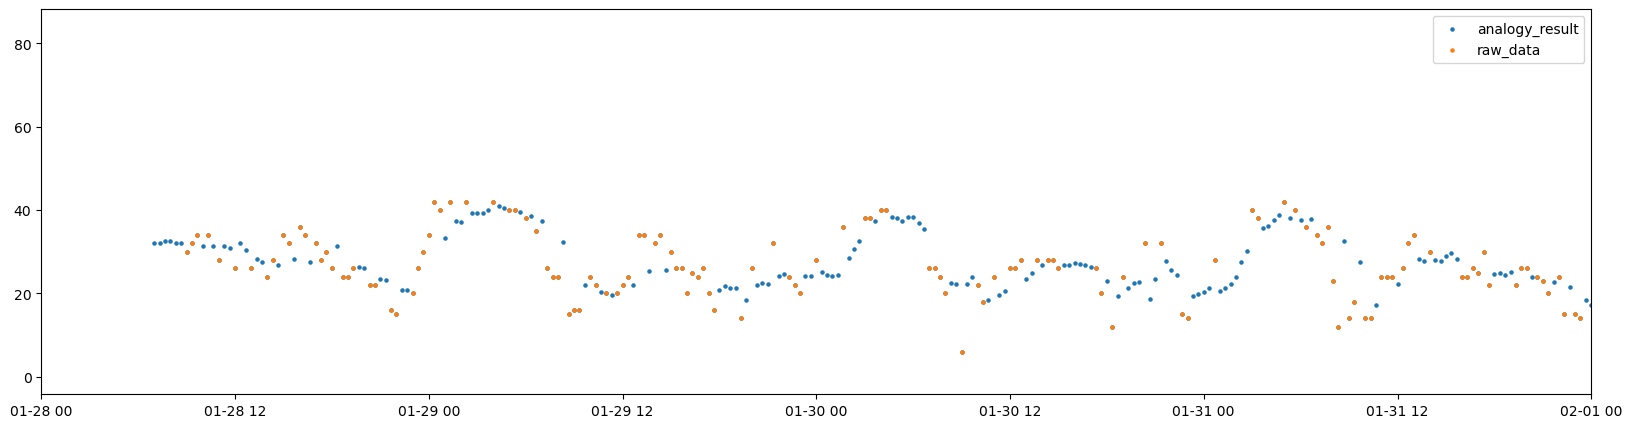

In [302]:
plt.figure(figsize=(20,5))
plt.scatter(result.index,result.values,label='analogy_result',s=5)
plt.scatter(tdf_filled.index,tdf_filled.values,label='raw_data',s=5)
# plt.plot(tdf_filled.index,tdf_filled.values)
plt.xlim(np.datetime64('2024-01-28'),np.datetime64('2024-02-01'))
plt.legend()
plt.show()

In [303]:
fontsize = 10
s = 8
edge_s = 0.1
linewidth = 1
colors = ['#F08E2A','#4F79A8','#E1575B']

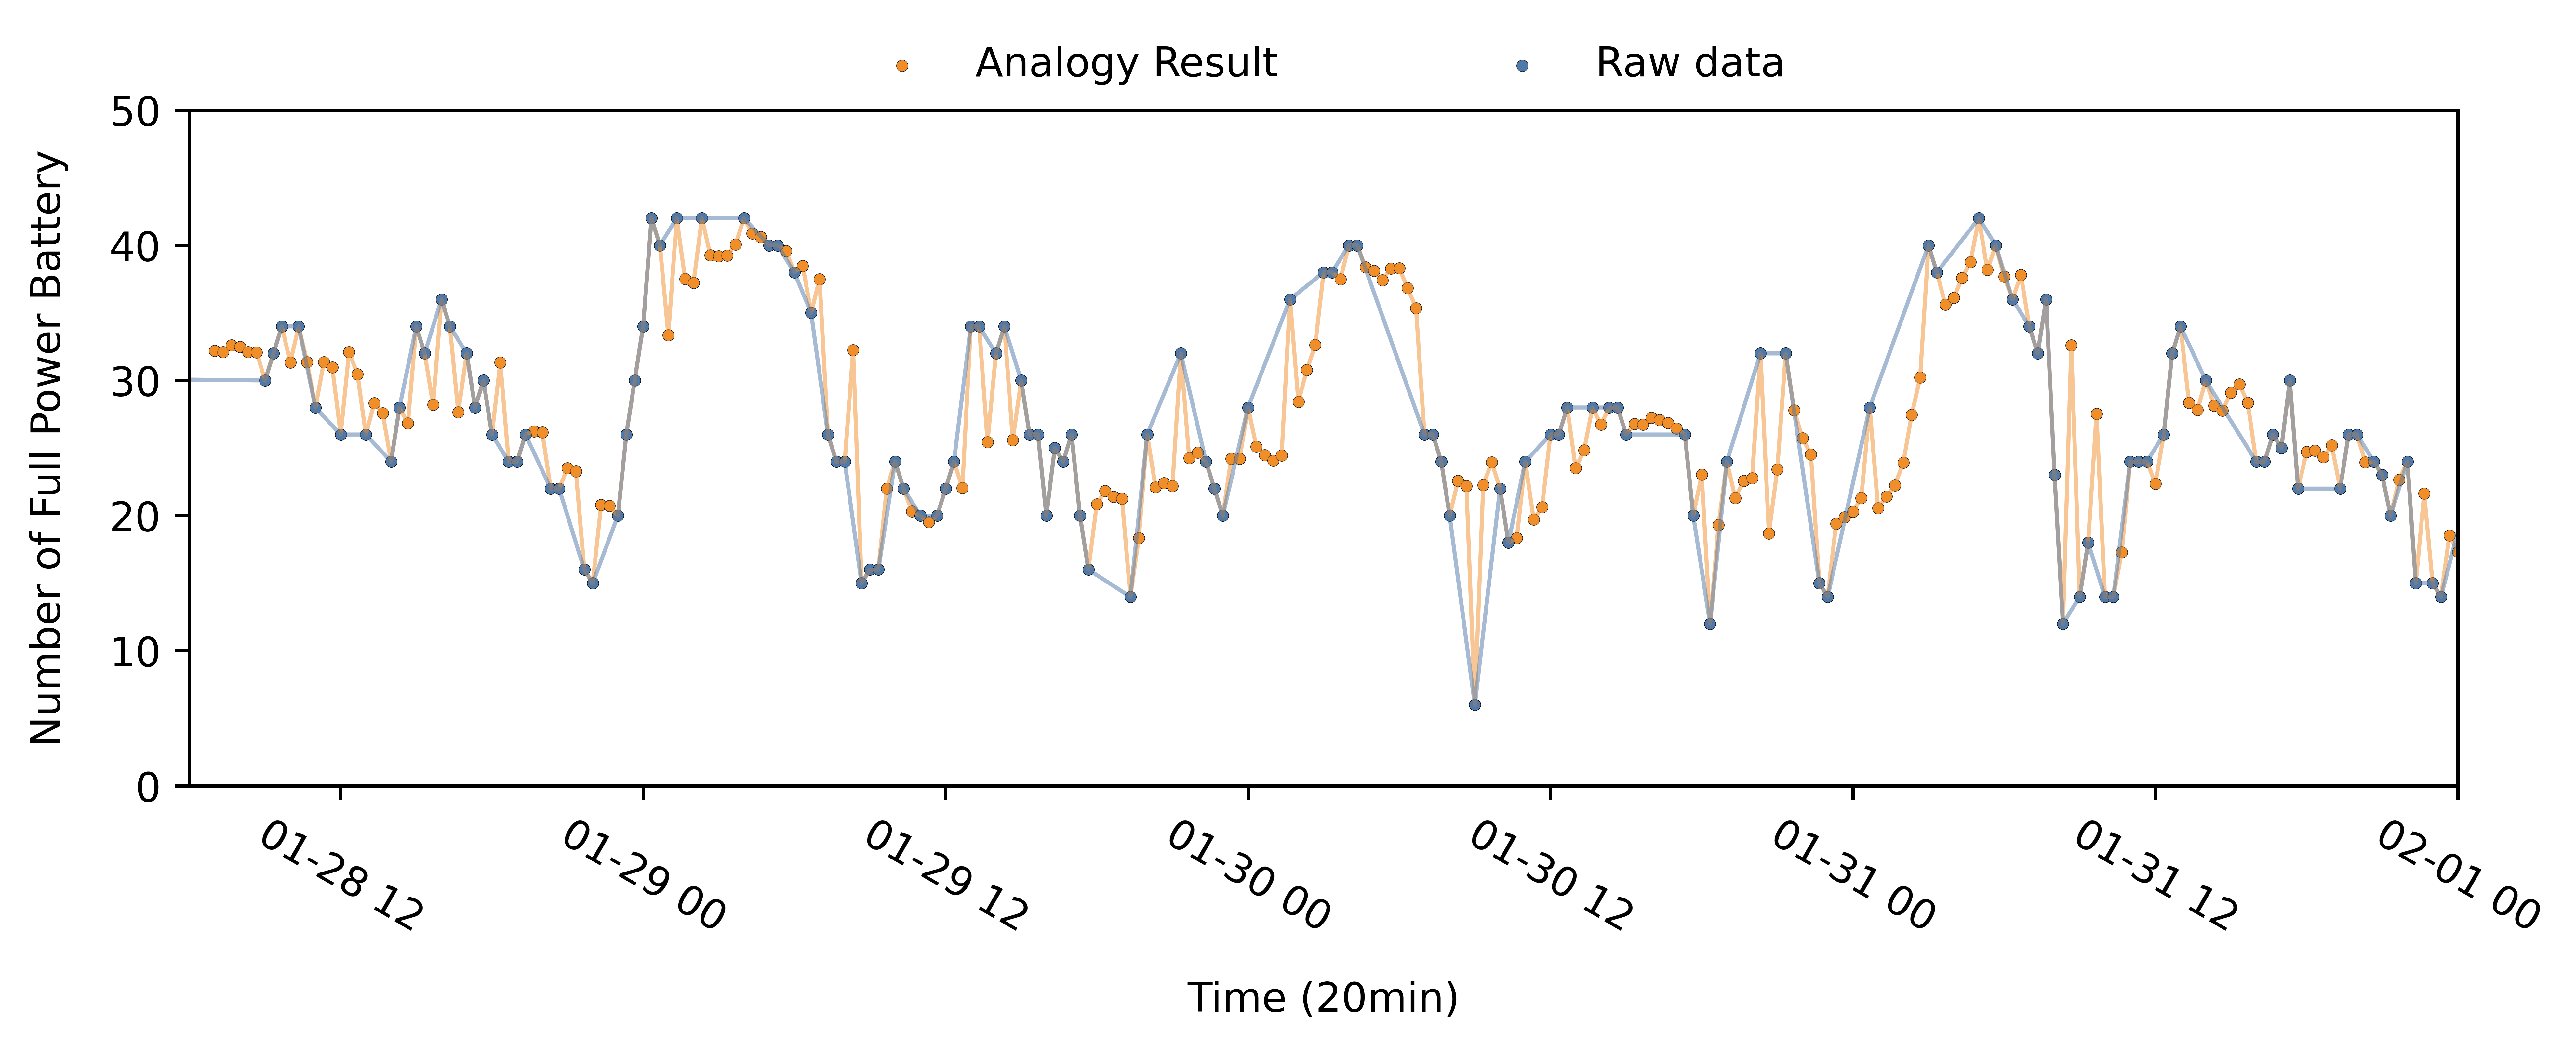

In [325]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3), dpi=900)

ax = axes
# ax.scatter(result.interpolate().index,result.interpolate().values,label='Missing Value',s=s,color=colors[2],linewidth=edge_s,edgecolors='black')
ax.scatter(result.index,result.values,label='Analogy Result',s=s,color=colors[0],linewidth=edge_s,edgecolors='black')
ax.plot(result.index,result.values,color=colors[0],linewidth=linewidth,alpha=0.5)

# ax.scatter(tdf_filled.interpolate().index,tdf_filled.interpolate().values,label='Missing Value',s=s,color=colors[2],linewidth=edge_s,edgecolors='black')
ax.scatter(tdf_filled.dropna().index,tdf_filled.dropna().values,label='Raw data',s=s,color=colors[1],linewidth=edge_s,edgecolors='black')
ax.plot(tdf_filled.dropna().index,tdf_filled.dropna().values,color=colors[1],linewidth=linewidth,alpha=0.5)

ax.set_xlim(np.datetime64('2024-01-28 06:00'),np.datetime64('2024-02-01'))
ax.set_ylim(0,50)
ax.set_xlabel('Time (20min)',fontsize=fontsize,labelpad=10)
ax.set_ylabel('Number of Full Power Battery',fontsize=fontsize,labelpad=10)
ax.tick_params(labelsize=fontsize,axis='both')
plt.setp(ax.get_xticklabels(), rotation=-30)
ax.legend(frameon=False,ncol=2,loc='upper center',bbox_to_anchor=(0.5, 1.15),columnspacing=5,fontsize=fontsize)
plt.show()

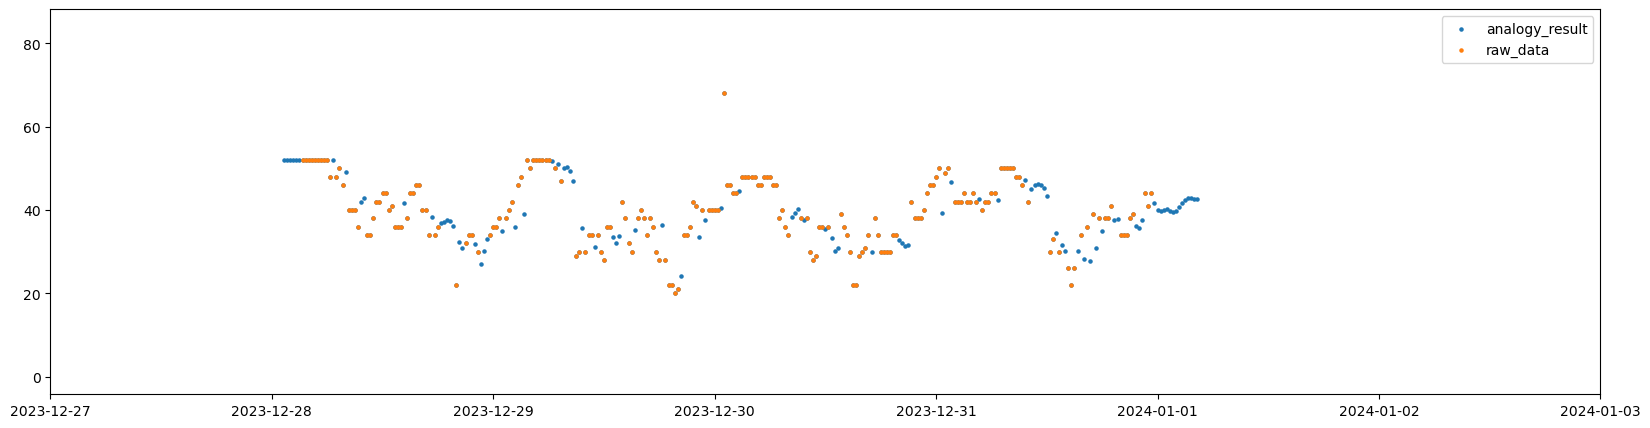

In [305]:
plt.figure(figsize=(20,5))
plt.scatter(result.index,result.values,label='analogy_result',s=5)
plt.scatter(tdf_filled.index,tdf_filled.values,label='raw_data',s=5)
# plt.plot(tdf_filled.index,tdf_filled.values)
plt.xlim(np.datetime64('2023-12-27'),np.datetime64('2024-01-03'))
plt.legend()
plt.show()

In [306]:
concat_df = pd.concat([result,tdf_filled],axis=1)

In [307]:
concat_df

,analogy_result,raw_data
2023-01-01 00:20:00,46.00000,46.0
2023-01-01 00:40:00,46.00000,46.0
2023-01-01 01:00:00,44.91745,NaN
2023-01-01 01:20:00,44.00000,44.0
2023-01-01 01:40:00,46.00000,46.0
...,...,...
2024-09-14 21:20:00,NaN,NaN
2024-09-14 21:40:00,NaN,NaN
2024-09-14 22:00:00,NaN,NaN
2024-09-14 22:20:00,NaN,NaN
